# 14.38 PS8
In this problem set I will be answering questions 2 and 3 from CM-4.

## Problem 2
In this problem, I will be explaining two different methods for arriving at an IV estimator: Wright's Causal Path Analysis and a Method of Moments. Consider the following DAG, with $A$ unobserved.


Attaching package: ‘ggdag’


The following object is masked from ‘package:stats’:

    filter




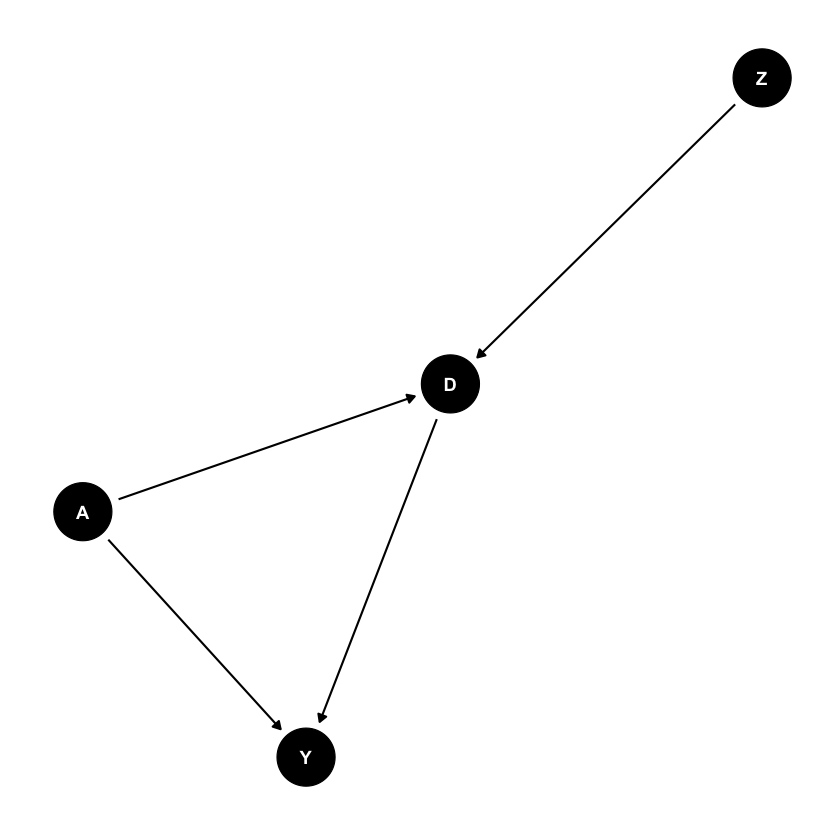

In [47]:
library(dagitty)
library(ggdag)

g <- dagitty("dag{
        D [treatment]
        Z [exposure]
        A [unobserved]
        Y [outcome]
        A -> Y
        D -> Y
        Z -> D
        A -> D
        
    }")

ggdag(g) + theme_dag()

This corresponds to the SEM

\begin{align*}
    Y &:= \alpha A + \delta D + \varepsilon_Y \\
    D &:= \beta Z + \gamma A + \varepsilon_D \\
    Z &:= \varepsilon_Z \\
    A &:= \varepsilon_A 
\end{align*}

We would like to derive a method of identifying the structural parameter $\delta$. Wright's causal path analysis does this by considering a "reduced form" regression of $Y$ on $Z$. From bivariate regression formulas (for centered $Y$ and $Z$), we have

\begin{gather*}
    Y = \rho Z + \mu \\
    \rho = \frac{E[YZ]}{E[Z^2]}
\end{gather*}

Substituting the structural formula for $Y$ into the expression above, we have

\begin{align*}
    \rho &= \frac{E[(\alpha A + \delta D + \varepsilon_Y)Z]}{E[Z^2]} \\
         &= \frac{\alpha E[AZ] + \delta E[DZ]}{E[Z^2]} \\
         &= \delta \frac{E[DZ]}{E[Z^2]} \\
         &= \delta \beta
\end{align*}

where the 3rd and 4th inequality both follow because $A$ and $Z$ are orthogonal. We can then consider

\begin{align*}
    \delta_{IV} &= \frac{E[YZ]}{E[DZ]} \\
    &= \frac{E[YZ]/E[Z^2]}{E[DZ]/E[Z^2]} \\
    &= \frac{\delta \beta}{\beta} \\
    &= \delta
\end{align*}

The method of moments estimation takes a different (and much simpler) approach. Consider the same SEM from above

\begin{align*}
    Y &:= \alpha A + \delta D + \varepsilon_Y \\
    D &:= \beta Z + \gamma A + \varepsilon_D \\
    Z &:= \varepsilon_Z \\
    A &:= \varepsilon_A 
\end{align*}

The expression for $Y$ can be written as

$$
Y = \delta D + U \\
U = \alpha A + \varepsilon_Y
$$

where $U \perp Z$ by the assumptions of the model. Therefore, we have

\begin{align*}
 0 &= E[UZ] \\
 &= E[(Y-\alpha D)Z]
\end{align*}

Solving this equation for $\alpha$, we get that

$$
    \alpha = \frac{E[YZ]}{E[DZ]}
$$

We can think about both of these approaches in an empirical example. Often in real world examples we have observed confounders $X$ that affect $Y$, $D$, $Z$, and $A$. However, with effective partialling out techniques (as in DML), we can partial them out before estimating our IV parameters. We will use data from Angrist & Krueger (1991), which examined the effects of education on schooling using an instrumental variables strategy. Specifically, they took advantage of local truancy laws that allowed students to drop out of school when they turned 16. Students born in the 1st quarter of each year and students born in the 4th quarter of each year would have completed different amounts of schooling by the time they turn 16, so the paper uses quarter-of-birth as an instrument for years of education completed. In this example, I will replicate some of the results from the paper using both the ratio method of constructing an IV estimator and method of moments. The SEM we use here is similar as that above, except $D$ is replaced by $S$, a variable for years of schooling.

In [48]:
library(foreign)
library(ivreg)
library(tidyverse)

ak91 <- read.dta("ak91.dta")

ak91$yob <- as.factor(ak91$yob)
ak91$qob <- as.factor(ak91$qob)

ak91 <- ak91 %>% mutate(qob4 = ifelse(qob == 4, 1, 0))

#using the ivreg function, using instrument for quarter-of-birth = 4
delta.tsls <- ivreg(lnw ~ s+yob | qob4, data=ak91)$coefficients[2]


#before we use the ratio method or method of moments, we want to partial out the year-of-birth controls
tilde.lnw <- ak91$lnw - predict(lm(lnw ~ yob, data=ak91), data=ak91)
tilde.s <- ak91$s - predict(lm(s ~ yob, data=ak91), data=ak91)
tilde.qob4 <- ak91$qob4 - predict(lm(qob4 ~ yob, data=ak91), data=ak91)

tilde.ak91 <- data.frame(tilde.lnw, tilde.s, tilde.qob4)

#ratio method
delta.ratio <- (lm(tilde.lnw ~ tilde.qob4, 
                   data=tilde.ak91)$coef[2])/(lm(tilde.s ~ tilde.qob4, 
                                                 data=tilde.ak91)$coef[2])

# method of moments
delta.mom <- mean(tilde.ak91$tilde.lnw*tilde.ak91$tilde.qob4)/mean(tilde.ak91$tilde.qob4*tilde.ak91$tilde.s)

cat("Unpartialled 2SLS estimator:", delta.tsls, "\n")
cat("Partialled ratio IV estimator:", delta.ratio, "\n")
cat("Partialled MoM IV estimator:", delta.mom)

Warning message in ivreg.fit(X, Y, Z, weights, offset, ...):
“more regressors than instruments”


Unpartialled 2SLS estimator: 0.07395893 
Partialled ratio IV estimator: 0.07520435 
Partialled MoM IV estimator: 0.07520435

The difference between the unpartialled 2SLS estimator comes from the fact that linear partialling out of the year-of-birth controls are not perfect, but they do end up being very close. The two partialled methods are of course the same, as they are algebraically identical.

## Problem 3 - Simulation
In this problem, I will construct simulated data from a causal DAG in a linear IV model. There will not be observed controls in this model, but the analysis could be extended by assuming that we partialled out observed controls. Consider the same DAG as before, where we again treat $A$ as unobserved.

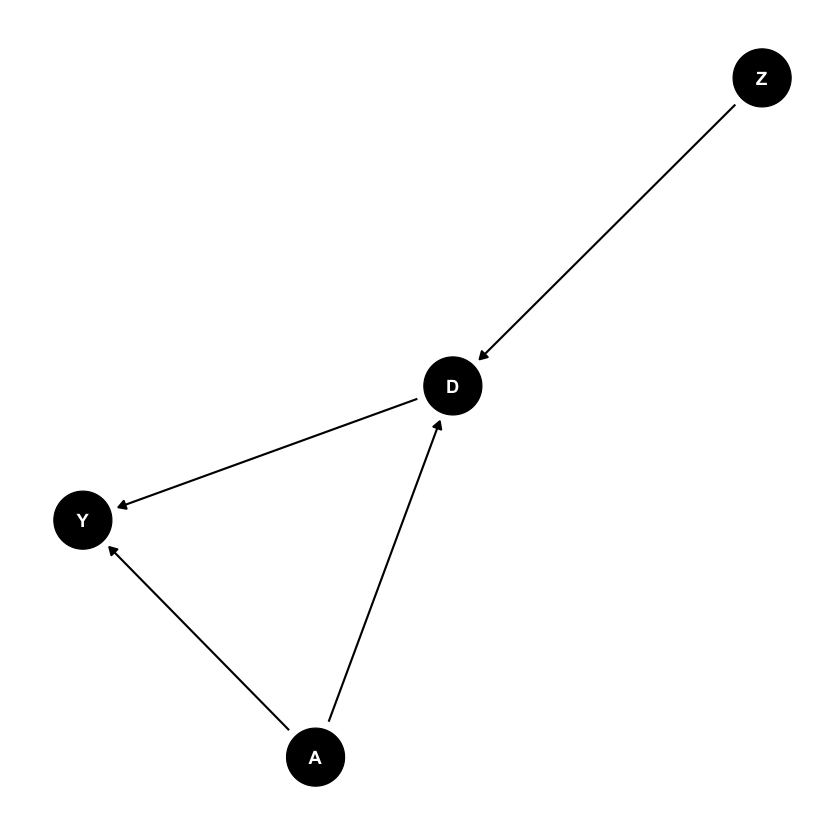

In [49]:
ggdag(g) + theme_dag()

The motivation for a DAG like this could be wage returns to schooling. If we observed $A$, an ability variable, then we could find the effect of $D$ (college attendence) on $Y$ (log wages) by conditioning on $A$. However, because we do not observe $A$, we must use IV methods (using the instrument $Z$, which could be something like random scholarship offer). We will treat the SEM corresponding to this DAG as linear. Specifically, we have

\begin{align*}
    Y &:= \alpha A + \delta D + \varepsilon_Y \\
    D &:= \beta Z + \gamma A + \varepsilon_D \\
    Z &:= \varepsilon_Z \\
    A &:= \varepsilon_A 
\end{align*}

Let's simulate this data, then conduct OLS regression and IV regression, comparing the two results.

In [50]:
library(purrr)
set.seed(1)

#parameters
n <- 100000
alpha <- 0.15
delta <- 0.1
beta <- 0.8
gamma <- 0.3

# variable construction
Z <- rbernoulli(n)
A <- rnorm(n)
D <- beta*Z + gamma*A + rnorm(n)
Y <- alpha*A + delta*D + rnorm(n, mean=2)

data <- data.frame(A, Z, D, Y)

In [51]:
ols <- lm(Y ~ D, data=data)
ols$coef

(Intercept)           D 
  1.9854543   0.1359585

In this framework, we can conduct IV in two ways. We can take the ratio of the reduced form estimate (OLS of $Y$ on $Z$) and the first stage estimate (OLS of $D$ on $Z$), or we can do two stage least squares (regress $Y$ on the fitted values from $D$ on $Z$).

In [52]:
# ratio method
hat.delta.ratio <- (lm(Y ~ Z, data=data)$coef[2])/(lm(D ~ Z, data=data)$coef[2])

# 2sls
first.stage <- lm(D ~ Z, data=data)
D.hat <- predict(first.stage, data=data)
data <- data.frame(data, D.hat)
hat.delta.2sls <- lm(Y ~ D.hat, data=data)$coef[2]

In [53]:
hat.delta.ratio
hat.delta.2sls

ZTRUE 
0.1028332

D.hat 
0.1028332

As we can see, either method gets the same value. This value is considerably closer to the true value of $\delta$, which is 0.1. Let's now run a simulation over many such samples to construct a distribution of both the naive OLS estimates and both kinds of IV estimates.

In [54]:
library(tidyverse)

#function for one round of simulation
draw <- function(n, alpha, delta, beta, gamma) {
    Z <- rbernoulli(n)
    A <- rnorm(n, sd=0.1)
    D <- beta*Z + gamma*A + rnorm(n, sd=0.1)

    Y <- alpha*A + delta*D + rnorm(n, mean=2, sd=0.1)

    data <- data.frame(A, Z, D, Y)
    
    #naive OLS
    ols <- lm(Y ~ D, data=data)
    delta.naive <- ols$coef[2]
    
    # ratio method
    delta.ratio <- (lm(Y ~ Z, data=data)$coef[2])/(lm(D ~ Z, data=data)$coef[2])

    
    as.data.frame(t(c(delta.naive, delta.ratio))) %>% 
        rename(OLS=D, Ratio=ZTRUE)
}

#function for full simulation
simulate <- function(N, n, alpha, delta, beta, gamma) {
    results <- draw(n, alpha, delta, beta, gamma)
    
    for(i in 2:N){
        results <- rbind(results, draw(n, alpha, delta, beta, gamma))
    }
    
    results
}

#parameters
N <- 1000
n <- 50000
alpha <- 0.4
delta <- 0.15
beta <- 0.5
gamma <- 0.5

set.seed(1)
simulation <- simulate(N, n, alpha, delta, beta, gamma)

      OLS             Ratio       
 Min.   :0.1703   Min.   :0.1437  
 1st Qu.:0.1755   1st Qu.:0.1488  
 Median :0.1768   Median :0.1501  
 Mean   :0.1767   Mean   :0.1501  
 3rd Qu.:0.1780   3rd Qu.:0.1514  
 Max.   :0.1820   Max.   :0.1561  

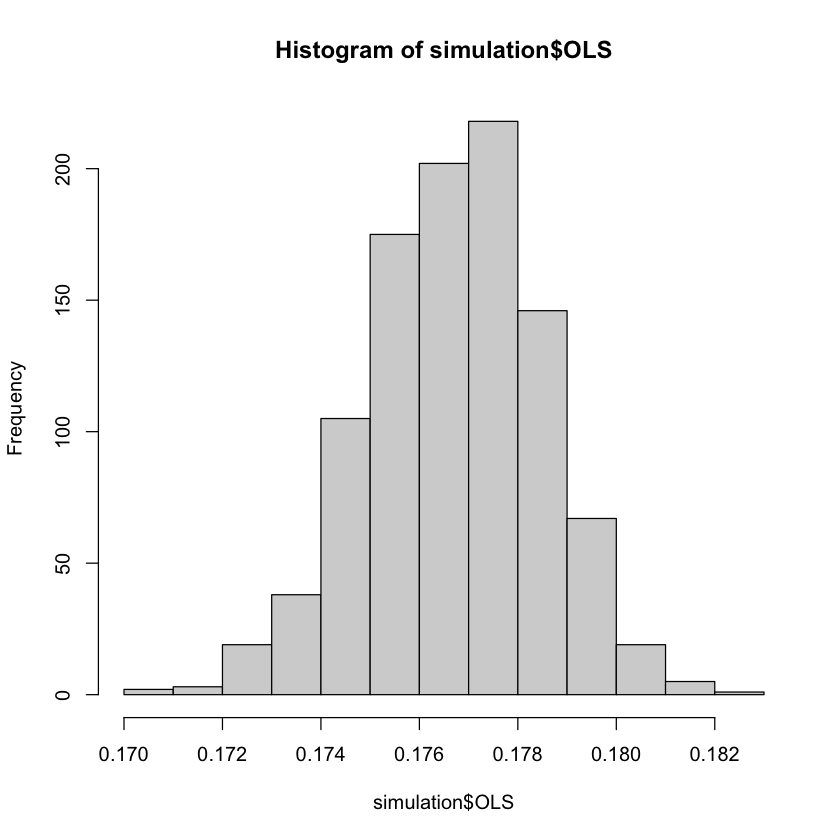

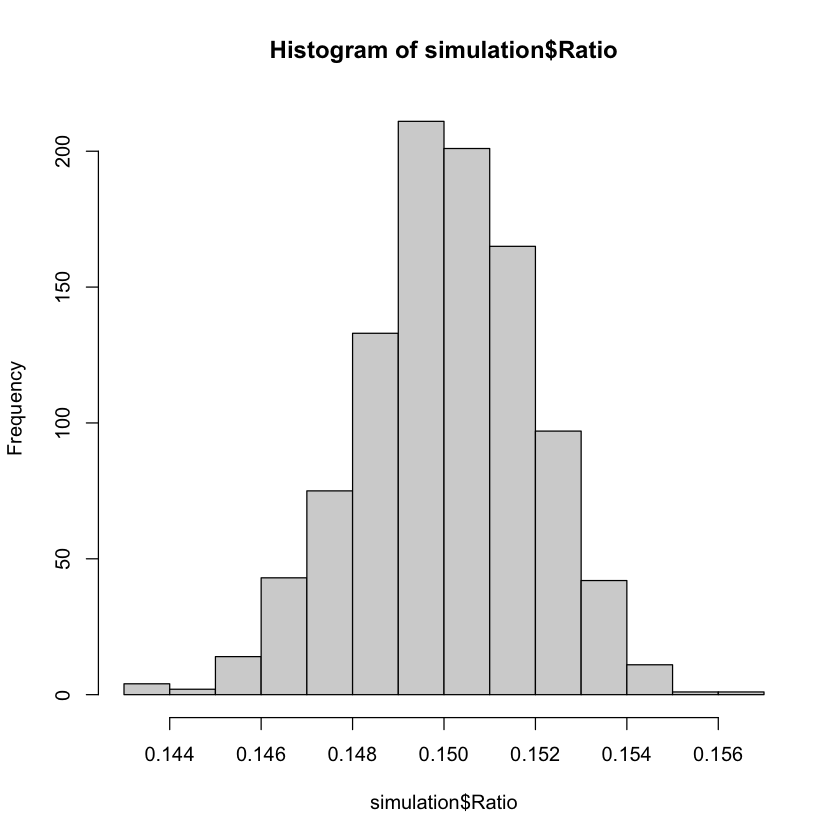

In [55]:
summary(simulation)

hist(simulation$OLS)
hist(simulation$Ratio)

As we can see, OLS deviates from the true value of $\delta$ considerably (the bias is about 0.025 log-points, which is a pretty large deviation in a context like this one). On the other hand, IV does quite well, nailing the value of $\delta=0.15$.